# Orthogonal Matching Pursuit (OMP)

## 1st Attempt - Parallelizing the OMP algorithm itself

### Imports

In [1]:
# Preparing the Spark Environment
from pyspark.sql import SparkSession
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

# Mllib items
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix
from pyspark.mllib.regression import *

# System, Numpy and WAV reading
import os
from scipy.io import wavfile
import numpy as np

# Plots
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (16,9)

# Normalization and Metrics
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error

### Definition of basic functions to work with Block Matrices

In [2]:
# Function to create a Block Matrix from a given Numpy Matrix

def par_BlockMatrix (M, numParts=1):
    
    try:
        [lins, cols] = M.shape
    except:
        lins = 1
        cols = len(M)
        pass
    
    flat_M = np.matrix.flatten(M, order='F')
    dense_M = Matrices.dense(lins, cols, flat_M)
    
    blocks = sc.parallelize(
        [
            ( (0, 0), dense_M )
        ], numParts
    )
    
    return BlockMatrix(blocks, lins, cols)

In [3]:
# Function to transpose a Block Matrix

def par_Transpose (Block_Matrix):
    return Block_Matrix.transpose()

In [41]:
# Function to multiply two given Block Matrices

def par_MatMultiply (M1, M2):
    try:
        M1 = par_Transpose(M1)
        result = M1.multiply(M2)
    except:
        M2 = par_Transpose(M2)
        result = M1.multiply(M2)
        
    return result

### Proof of concept for the functions for Block Matrices

In [5]:
# Creating simple Numpy matrices m1 and m2

m1 = np.array([[5, 6, 7], [8, 9, 0]])
m2 = np.array([[1, 2], [3, 4], [5, 6]])

In [6]:
# Creating Block Matrices M1 and M2 from the Numpy matrices m1 and m2

M1 = par_BlockMatrix(m1, 1)
M2 = par_BlockMatrix(m2, 1)

In [7]:
# Transposition of the Block Matrix M1

par_Transpose(M1).toLocalMatrix().toArray()

array([[5., 8.],
       [6., 9.],
       [7., 0.]])

In [8]:
# Multiplication of the Block Matrix M1 by the Block Matrix M2

par_MatMultiply(M1, M2).toLocalMatrix().toArray()

array([[21., 47., 73.],
       [24., 54., 84.],
       [ 7., 21., 35.]])

### Creating the Dictionary (matrix)

In [9]:
# Setting the directories and Listing files

violaoWaveDir = 'audio/violao/used/'
violaoWaveList = sorted(os.listdir(violaoWaveDir))

pianoWaveDir = 'audio/piano/used/'
pianoWaveList = sorted(os.listdir(pianoWaveDir))

In [10]:
# Importing WAV files

violaoDict = []
for audioFile in violaoWaveList:
    violaoDict.append(wavfile.read(violaoWaveDir + audioFile)[1])
    
pianoDict = []
for audioFile in pianoWaveList:
    pianoDict.append(wavfile.read(pianoWaveDir + audioFile)[1])

In [11]:
# Creating the basis for the Dictionary

Dict = []
Dict.extend(violaoDict)
Dict.extend(pianoDict)

Dict = np.asarray(Dict)
Dict.shape

(20000, 4410)

In [12]:
# Function to remove the null signals

def clearSilence (signals, threshold=0.1):    
    s = []
    for i in range(signals.shape[0]):
        if any(elem > threshold for elem in signals[i]):
            s.append(signals[i])
    s = np.asarray(s)
    
    return s

In [13]:
# Creating the Dictionary (D) with "clean" signals only

D = np.transpose(clearSilence(Dict))

### Preparing the Test Data

In [14]:
# Setting the directories and listing files

testWaveDir = 'audio/TEST/'
testWaveList = sorted(os.listdir(testWaveDir))

In [15]:
# Importing WAV files

testData = []
for audioFile in testWaveList:
    testData.append(wavfile.read(testWaveDir + audioFile)[1])

In [16]:
# Normalizing all data

testData = normalize(testData, axis=1, norm='l2')
D = normalize(D, axis=0, norm='l2')

### The OMP function and it's parallelized version

In [26]:
# OMP function

def omp(D,s,k):
    """
    Orthogonal Matching Pursuit (OMP)
        
    Inputs
        D: dictionary (matrix)
        s: signal
        k: sparsity level
        
    Output
        x: coeff vector for sparse representation
    """
    
    [l, c] = D.shape
    
    x = np.zeros([c, 1]) # coefficient (output)
    r = s # residual of s
    omega = np.zeros([k, 1]) # selected support
    D_omega = np.zeros([l, 1]) # correspondng columns of D
    
    for cnt in range(k): # choose k atoms
        print("Iteration: ", cnt)
        x_tmp = np.zeros([c, 1])
        inds = np.setdiff1d(np.arange(0,c-1), omega)
        
        for i in inds:
            t = np.transpose(D[:, i])
            n = np.linalg.norm(D[:, i])
            x_tmp[i] = np.matmul(t,r) / n
        
        ichosen = np.argmax(abs(x_tmp))
        omega[cnt] = ichosen
        D_omega = np.column_stack([D_omega, D[:, ichosen]])
        if (cnt == 0):
            D_omega = np.delete(D_omega, 0, 1)
        x_ls = np.linalg.lstsq(D_omega, s, rcond=None)[0]
        r = s - np.matmul(D_omega, x_ls)
    
    for a in range(k):
        x[int(omega[a])] = x_ls[a]

    return x

In [47]:
# Parallelized OMP function

PARTS = 1

def par_omp(D, s, k):
    [l, c] = D.shape
    
    x = np.zeros([c, 1])
    r = s
    omega = np.zeros([k, 1])
    D_omega = np.zeros([l, 1])
    
    for cnt in range(k):
        print("Iteration: ", cnt)
        bm_r = par_BlockMatrix(r, PARTS)
        
        x_tmp = np.zeros([c, 1])
        inds = np.setdiff1d(np.arange(0, c-1), omega)
        
        for i in inds:
            bm_Di = par_BlockMatrix(D[:, i], PARTS)
            
            t = par_Transpose(bm_Di)
            x_tmp[i] = par_MatMultiply(t, bm_r).toLocalMatrix().toArray()
            
        ichosen = np.argmax(abs(x_tmp))
        omega[cnt] = ichosen
        D_omega = np.column_stack([D_omega, D[:, ichosen]])
        
        if (cnt == 0):
            D_omega = np.delete(D_omega, 0, 1)
        
        rdd_D_omega = sc.parallelize(enumerate(D_omega), PARTS)
        data = rdd_D_omega.map(parse_LP)
        x_ls = np.linalg.lstsq(D_omega, s, rcond=None)[0]
        
        r = s - np.matmul(D_omega, x_ls)
        
    for a in range(k):
        x[int(omega[a])] = x_ls[a]
        
    return x

In [28]:
# Function to create Labeled Points from inputs

def parse_LP (signal):
    return LabeledPoint(signal[0], signal[1:])

### Tests

#### Non-Parallel

In [48]:
%%time
x = omp(D[:100,:200], testData[0,:100].reshape(100,1), 20)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
CPU times: user 45.2 ms, sys: 664 µs, total: 45.9 ms
Wall time: 38.2 ms


In [30]:
# Reconstruction of the original signal using the OMP generated coefficients

S = np.matmul(D[:100, :200], x)

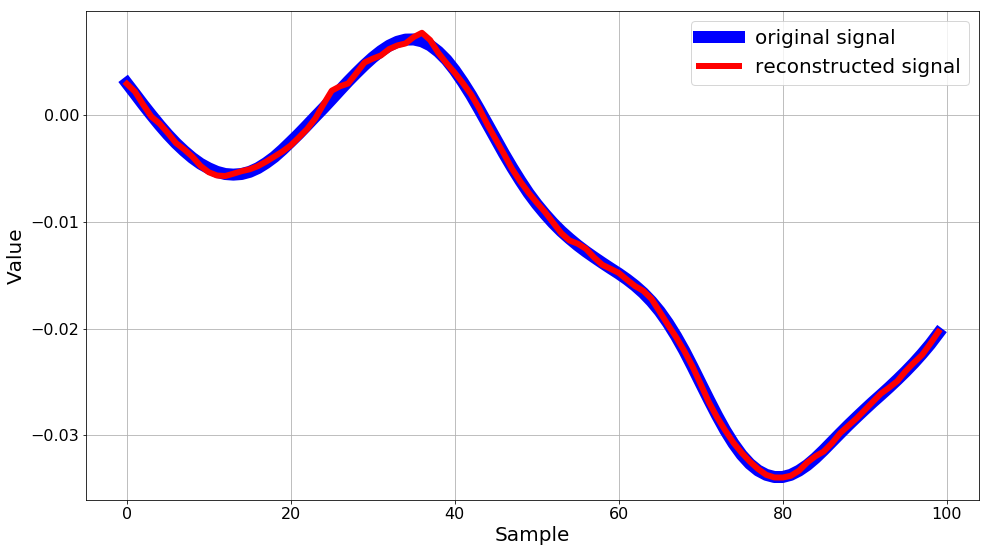

In [90]:
# Plot of original signal and reconstructed signal using serial OMP

%matplotlib inline

mpl.rcParams['figure.figsize'] = (16,9)

plt.plot(testData[0,:100], 'b', lw=12, alpha=1, label='original signal')
plt.plot(S, 'r', lw=6, alpha=1, label='reconstructed signal')
plt.legend(loc=1, prop={'size': 20})
plt.xlabel('Sample', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.grid()
plt.tick_params(labelsize=16)

plt.savefig('serial_omp.pdf')

plt.show()

In [32]:
# Mean Squared Error

MSE = mean_squared_error(S, testData[0, :100])
print(MSE)

4.570238240697458e-08


#### Parallel

In [49]:
%%time
x_par = par_omp(D[:100,:200], testData[0,:100].reshape(100,1), 20)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
CPU times: user 1min 3s, sys: 8.57 s, total: 1min 11s
Wall time: 18min 19s


In [50]:
# Reconstruction of the original signal using the Parallel OMP generated coefficients

S_par = np.matmul(D[:100, :200], x_par)

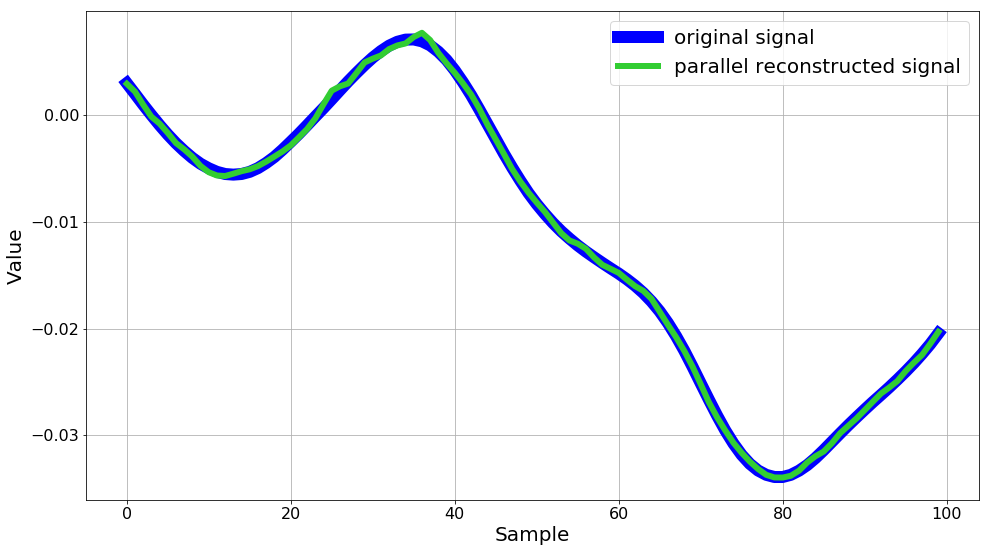

In [91]:
# Plot of original signal and reconstructed signal using parallel OMP

%matplotlib inline

mpl.rcParams['figure.figsize'] = (16,9)

plt.plot(testData[0,:100], 'b', lw=12, alpha=1, label='original signal')
plt.plot(S, 'limegreen', lw=6, alpha=1, label='parallel reconstructed signal')
plt.legend(loc=1, prop={'size': 20})
plt.xlabel('Sample', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.grid()
plt.tick_params(labelsize=16)

plt.savefig('omp_parallel.pdf')

plt.show()

In [52]:
# Mean Squared Error

MSE = mean_squared_error(S_par, testData[0, :100])
print(MSE)

4.415687705930461e-08


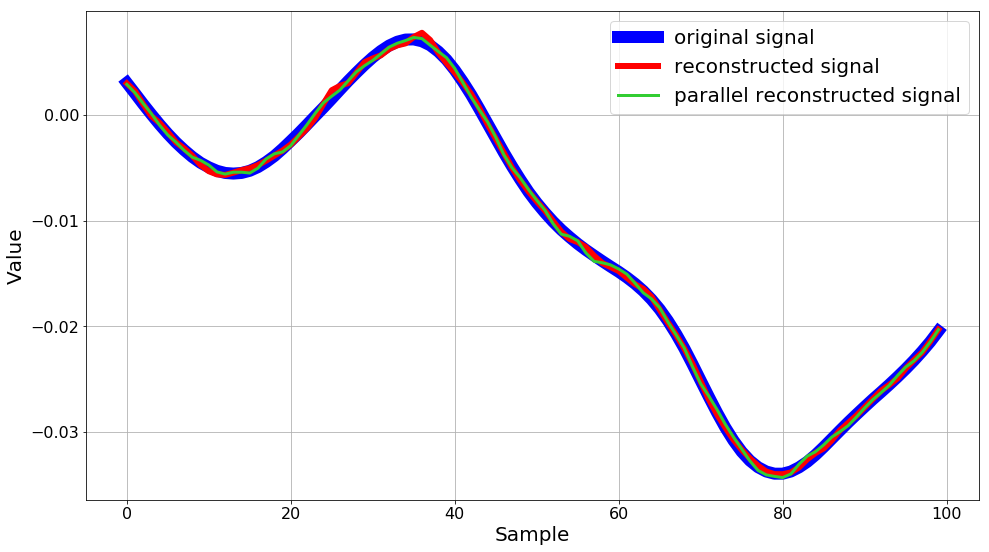

In [92]:
# Plot of original signal and reconstructed signal using serial and parallel OMP

%matplotlib inline

mpl.rcParams['figure.figsize'] = (16,9)

plt.plot(testData[0,:100], 'b', lw=12, alpha=1, label='original signal')
plt.plot(S, 'r', lw=6, alpha=1, label='reconstructed signal')
plt.plot(S_par, 'limegreen', lw=3, alpha=1, label='parallel reconstructed signal')
plt.legend(loc=1, prop={'size': 20})
plt.xlabel('Sample', fontsize=20)
plt.ylabel('Value', fontsize=20)
plt.grid()
plt.tick_params(labelsize=16)

plt.savefig('omp_serial_parallel.pdf')

plt.show()